The most basic DE involving with periodicity would be
$$
\frac{df}{dx}=\cos(x) \\
f=\sin(x)+C
$$
Let initial value be $f(0)=1, C=1$.

In [37]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def set_seed(seed: int = 42) -> None:
    """Set the random seed for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)

# Define the differential equation: y' = cos(x)
def differential_equation(x: torch.Tensor) -> torch.Tensor:
    return torch.cos(x)

# Define the analytic solution
def analytic_solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(x)

class ApproximatorNet(nn.Module):
    def __init__(self, input_size: int = 1, output_size: int = 1, hidden_layers: int = 5, hidden_nodes: int = 10) -> None:
        super().__init__()

        self.inputs = nn.Linear(input_size, hidden_nodes)
        self.model = nn.ModuleList([nn.Linear(hidden_nodes, hidden_nodes)] * hidden_layers)
        self.outputs = nn.Linear(hidden_nodes, output_size)
        self.activation = nn.Tanh() ## other activation functions: ReLU, softmax, GeLu

    def _apply_model(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.model:
            x = self.activation(layer(x))
        return x

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = self.activation(self.inputs(t))
        t = self._apply_model(t)
        t = self.outputs(t)
        return t

In [27]:
# Training data (30)
x_data = np.linspace(0, 3*np.pi, 101)  # Adjust the range to avoid division by zero
x_data = torch.tensor(x_data)
y_data = analytic_solution(x_data)
#y_data += 0.01 * np.random.randn(*y_data.shape) # even if I add this the prediction was accuracy

# Convert training data to PyTorch tensors
x_data_t = torch.tensor(x_data[1:101:25], dtype=torch.float32).unsqueeze(1)
y_data_t = torch.tensor(y_data[1:101:25], dtype=torch.float32).unsqueeze(1)

x_data_init = torch.tensor(x_data[0], dtype=torch.float32).unsqueeze(-1)  # Initial condition
y_data_init = torch.tensor(y_data[0], dtype=torch.float32).unsqueeze(-1)  # Initial condition value

In [22]:
x_data.shape, y_data.shape, x_data_init.shape, y_data_init.shape, x_data_t.shape, y_data_t.shape
# x_data_init, y_data_init

(torch.Size([101]),
 torch.Size([101]),
 torch.Size([1]),
 torch.Size([1]),
 torch.Size([4, 1]),
 torch.Size([4, 1]))

In [28]:
data_loss = nn.MSELoss()
def initial_loss(model: nn.Module, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    y_pred = model(x)
    return data_loss(y_pred, y)**2

In [64]:
# Hyperparameters
EPOCHS = 10000
LR = 1e-3

set_seed(42)  # Set seed for reproducibility

# Create the model
model = ApproximatorNet(hidden_layers=8, hidden_nodes=64)
optim = torch.optim.Adam(model.parameters(), lr=LR)
x_data_t.requires_grad = True

# Training loop
for epoch in range(EPOCHS+1):
    optim.zero_grad()

    # Data loss
    y_pred = model(x_data_t)
    loss_u = data_loss(y_pred, y_data_t)
    
    # Initial condition loss
    loss_i = initial_loss(model, x_data_init, y_data_init)
    
    # yhat
    y_pred = model(x_data_t)
    # dy_hat / dx
    dy_dx = torch.autograd.grad(y_pred, x_data_t, torch.ones_like(y_pred), create_graph=True)[0]

    # Physics loss
    loss_f = data_loss((dy_dx - differential_equation(x_data_t)), torch.zeros_like(y_data_t))  # DE loss
    
    lambda_f = 20.0  # Coefficient for the physics loss
    lambda_i = 1e-3  # Coefficient for the initial condition loss
    
    loss = loss_u + lambda_f*loss_f + lambda_i*loss_i # coefficients can be adjusted to balance the losses
    # loss = loss_u + loss_f + loss_i
    
    # Backpropagation
    loss.backward()
    optim.step()

    if epoch % 1000 == 0:
        print(f"Epochs {epoch}: D={float(loss_u):.10f}, P={float(loss_f):.10f}, I={float(loss_i):.10f}  L = {float(loss):.10f}")
        # adjust the lr
        if epoch > 0 and epoch % 2000 == 0:
            print(f"Reducing learning rate to {LR * 0.5:.6f}")
            LR *= 0.5
            for param_group in optim.param_groups:
                param_group['lr'] = LR
            
        
        
# try to change the number of epochs, hidden layers, and nodes ... it can significantly improves/worsen the results
# changing coefficients lambda_f and lambda_i can also improve the results
# 20000 might be overkill

Epochs 0: D=0.487727225, P=0.500564098, I=0.000023605  L = 10.499009132
Epochs 1000: D=0.000634445, P=0.000139440, I=0.000000000  L = 0.003423238
Epochs 2000: D=0.000143292, P=0.000074148, I=0.000000000  L = 0.001626262
Reducing learning rate to 0.000500
Epochs 3000: D=0.000000000, P=0.000000000, I=0.000000000  L = 0.000000000
Epochs 4000: D=0.000002293, P=0.000001065, I=0.000000000  L = 0.000023594
Reducing learning rate to 0.000250
Epochs 5000: D=0.000000000, P=0.000000000, I=0.000000000  L = 0.000000000
Epochs 6000: D=0.000000000, P=0.000000000, I=0.000000000  L = 0.000000000
Reducing learning rate to 0.000125
Epochs 7000: D=0.000000000, P=0.000000000, I=0.000000000  L = 0.000000000
Epochs 8000: D=0.000000000, P=0.000000000, I=0.000000000  L = 0.000000000
Reducing learning rate to 0.000063
Epochs 9000: D=0.000000000, P=0.000000000, I=0.000000000  L = 0.000000000
Epochs 10000: D=0.000000000, P=0.000000000, I=0.000000000  L = 0.000000000
Reducing learning rate to 0.000031


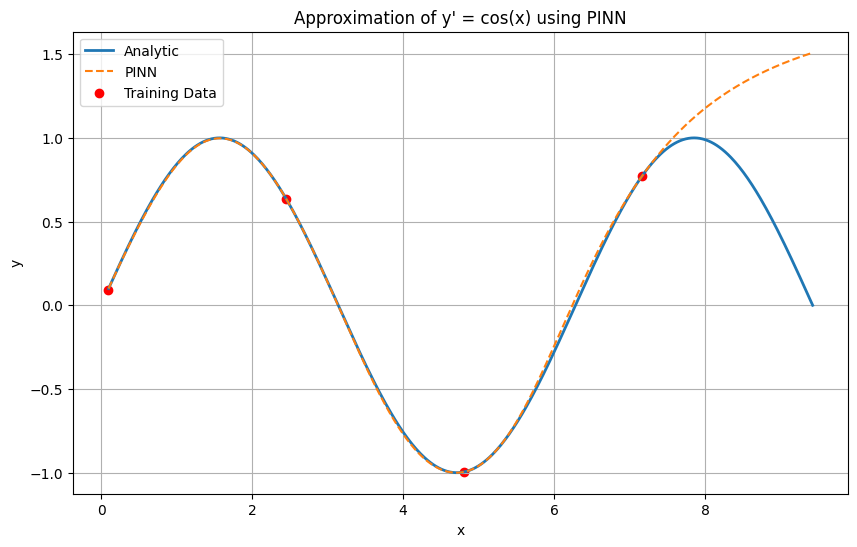

In [65]:
# some debugging helped by chatGPT (not getting used to tensor itself yet)
# Evaluate the model
model.eval()
x = np.linspace(0.1, 3*np.pi, 500)
x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_pred = model(x_t).detach().numpy().squeeze()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, analytic_solution(torch.tensor(x)), label="Analytic", linewidth=2)
plt.plot(x, y_pred, label="PINN", linestyle='--')
plt.scatter(x_data_t.detach().numpy(), y_data_t.detach().numpy(), c="r", label="Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Approximation of y' = cos(x) using PINN")
plt.legend()
plt.grid(True)
plt.show()

DNN Epochs 0: Loss = 0.4979297221
DNN Epochs 1000: Loss = 0.0000000000
DNN Epochs 2000: Loss = 0.0000000000
Reducing learning rate to 0.000500
DNN Epochs 3000: Loss = 0.0000000000
DNN Epochs 4000: Loss = 0.0000000000
Reducing learning rate to 0.000250
DNN Epochs 5000: Loss = 0.0000000000
DNN Epochs 6000: Loss = 0.0000000000
Reducing learning rate to 0.000125
DNN Epochs 7000: Loss = 0.0000000000
DNN Epochs 8000: Loss = 0.0000000000
Reducing learning rate to 0.000063
DNN Epochs 9000: Loss = 0.0000000000
DNN Epochs 10000: Loss = 0.0000000000
Reducing learning rate to 0.000031


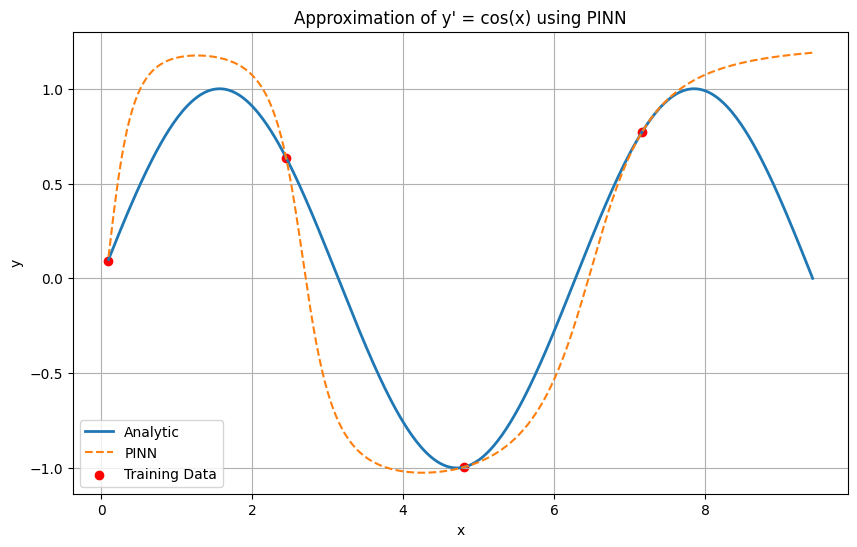

In [ ]:
# just a DNN for comparison
class DNN(nn.Module):
    def __init__(self, input_size: int = 1, output_size: int = 1, hidden_layers: int = 5, hidden_nodes: int = 10) -> None:
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_nodes))
        layers.append(nn.Tanh())
        
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_nodes, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
    
# Hyperparameters
EPOCHS = 10000
LR = 1e-3

set_seed(42)  # Set seed for reproducibility

# Create the DNN model
dnn_model = DNN(hidden_layers=8, hidden_nodes=64)
# Training the DNN model
dnn_optim = torch.optim.Adam(dnn_model.parameters(), lr=LR)
# Training loop for DNN
for epoch in range(EPOCHS+1):
    dnn_optim.zero_grad()
    y_pred_dnn = dnn_model(x_data_t)
    loss_dnn = data_loss(y_pred_dnn, y_data_t)
    loss_dnn.backward()
    dnn_optim.step()

    if epoch % 1000 == 0:
        print(f"DNN Epochs {epoch}: Loss = {float(loss_dnn):.10f}")
        if epoch > 0 and epoch % 2000 == 0:
            print(f"Reducing learning rate to {LR * 0.5:.6f}")
            LR *= 0.5
            for param_group in optim.param_groups:
                param_group['lr'] = LR        



In [ ]:
# Evaluate the model
dnn_model.eval()
x = np.linspace(0.1, 3*np.pi, 500)
x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_pred = dnn_model(x_t).detach().numpy().squeeze()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, analytic_solution(torch.tensor(x)), label="Analytic", linewidth=2)
plt.plot(x, y_pred, label="PINN", linestyle='--')
plt.scatter(x_data_t.detach().numpy(), y_data_t.detach().numpy(), c="r", label="Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Approximation of y' = cos(x) using DNN")
plt.legend()
plt.grid(True)
plt.show()